In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from tensorflow.keras.callbacks import History
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# import dataset and shuffle data
df = pd.read_csv('dataset_2.csv')
df = df.sample(frac=1).reset_index(drop=True)
df['Head Pressure'] = df['Head Pressure'].div(500)
df['Hip Bone Pressure'] = df['Hip Bone Pressure'].div(500)
df['Legs Pressure'] = df['Legs Pressure'].div(500)
df


,Head X,Head Y,Head Pressure,Hip Bone X,Hip Bone Y,Hip Bone Pressure,Legs X,Legs Y,Legs Pressure,Subject,Position
0,15.976744,10.034884,0.100112,16.494382,28.808989,0.293937,15.320513,49.525641,0.100206,3,0
1,15.800000,2.400000,0.391339,15.200000,33.525000,0.430185,14.584416,39.324675,0.436740,10,0
2,22.457627,10.322034,0.148207,21.039604,26.970297,0.359394,19.428571,47.457143,0.122382,10,2
3,16.729730,10.594595,0.177427,16.561905,25.857143,0.238698,14.822222,51.888889,0.118313,11,0
4,25.571429,10.261905,0.107977,23.840000,28.320000,0.248219,24.581081,50.383784,0.018318,10,2
...,...,...,...,...,...,...,...,...,...,...,...
2667,17.708333,9.166667,0.301680,16.537931,25.193103,0.142300,14.500000,50.048387,0.096027,7,0
2668,15.000000,9.000000,1.000000,13.030303,28.030303,0.173874,23.500000,50.000000,0.003877,8,2
2669,16.000000,3.500000,0.425612,17.391304,25.678261,0.080926,14.000000,60.000000,1.000000,2,0
2670,20.622222,10.022222,0.559285,19.923077,24.752137,0.440998,21.473684,43.776316,0.458533,2,2


In [3]:
# Split dataset in train, val and test
num_col = len(df.columns)
train_split = 2400
test_split = 2600

train_data = df.iloc[0:train_split, 0:num_col-2]
val_data = df.iloc[train_split:test_split, 0:num_col-2]

train_subject = df.iloc[0:train_split, num_col-2:num_col-1]
train_position = df.iloc[0:train_split, num_col-1:num_col]
val_subject = df.iloc[train_split:test_split, num_col-2:num_col-1]
val_position = df.iloc[train_split:test_split, num_col-1:num_col]

test_data_p = df.iloc[test_split:,:num_col-2]
test_subject = df.iloc[test_split:, num_col-2:num_col-1]
test_position = df.iloc[test_split:, num_col-1:num_col]

test_data_p = np.array(test_data_p)
test_subject = np.array(test_subject)
test_position = np.array(test_position)

test_subject = to_categorical(test_subject)
test_position = to_categorical(test_position)

while test_subject.shape[1] != 13:
    df = df.sample(frac=1).reset_index(drop=True)
    train_data = df.iloc[0:train_split, 0:num_col-2]
    val_data = df.iloc[train_split:test_split, 0:num_col-2]

    train_subject = df.iloc[0:train_split, num_col-2:num_col-1]
    train_position = df.iloc[0:train_split, num_col-1:num_col]
    val_subject = df.iloc[train_split:test_split, num_col-2:num_col-1]
    val_position = df.iloc[train_split:test_split, num_col-1:num_col]

    test_data_p = df.iloc[test_split:,:num_col-2]
    test_subject = df.iloc[test_split:, num_col-2:num_col-1]
    test_position = df.iloc[test_split:, num_col-1:num_col]

    test_data_p = np.array(test_data_p)
    test_subject = np.array(test_subject)
    test_position = np.array(test_position)
    test_subject = to_categorical(test_subject)
    test_position = to_categorical(test_position)


In [4]:
# convert to numpy array
train_data = np.array(train_data)
val_data = np.array(val_data)

train_subject = np.array(train_subject)
train_position = np.array(train_position)
val_subject = np.array(val_subject)
val_position = np.array(val_position)

print(train_data.shape)
print(train_subject.shape)
print(train_position.shape)
print(val_data.shape)
print(val_subject.shape)
print(val_position.shape)


(2400, 9)
(2400, 1)
(2400, 1)
(200, 9)
(200, 1)
(200, 1)


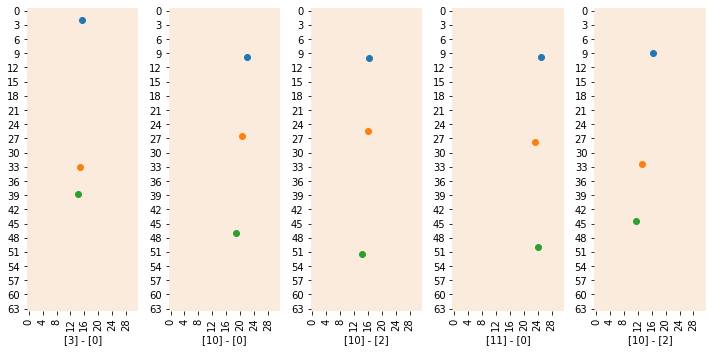

In [5]:
plt.figure(figsize=(10,5))
i = 0

for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    label = str(train_subject[i-1]) + ' - ' + str(train_position[i-1])
    sns.heatmap(np.zeros(2048).reshape(64,32),  vmin=-2, cbar=False)
    plt.plot(train_data[i][0],train_data[i][1], 'o')
    plt.plot(train_data[i][3],train_data[i][4], 'o')
    plt.plot(train_data[i][6],train_data[i][7], 'o')
    plt.xlabel(label)

plt.tight_layout()
    

In [6]:
# normalize data and build categorical labels
train_subject = to_categorical(train_subject, 13)
train_position = to_categorical(train_position, 3)
val_subject = to_categorical(val_subject, 13)
val_position = to_categorical(val_position, 3)


In [7]:
# model implementation
inp = 9

model_position = Sequential()
model_position.add(Dense(64, input_dim= inp, activation='relu'))
model_position.add(Flatten())
model_position.add(Dropout(0.4))
model_position.add(Dense(32, activation='relu'))
model_position.add(Dense(32, activation='relu'))
model_position.add(Dense(16, activation='relu'))
model_position.add(Dense(9, activation='relu'))

model_position.add(Dense(3, activation='softmax'))


In [8]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

model_position.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])

model_position.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 1

In [9]:
#train subject model
history = History()

train_position = model_position.fit(train_data, train_position, validation_data = (val_data, val_position), epochs=250,  callbacks = [history])


Epoch 1/250
75/75 [==============================] - 1s 8ms/step - loss: 1.1707 - accuracy: 0.5033 - val_loss: 1.0246 - val_accuracy: 0.5050
Epoch 2/250
75/75 [==============================] - 0s 3ms/step - loss: 0.9806 - accuracy: 0.5433 - val_loss: 0.9734 - val_accuracy: 0.5050
Epoch 3/250
75/75 [==============================] - 0s 3ms/step - loss: 0.9378 - accuracy: 0.5646 - val_loss: 0.8581 - val_accuracy: 0.6200
Epoch 4/250
75/75 [==============================] - 0s 3ms/step - loss: 0.8413 - accuracy: 0.6121 - val_loss: 0.7459 - val_accuracy: 0.6350
Epoch 5/250
75/75 [==============================] - 0s 3ms/step - loss: 0.7777 - accuracy: 0.6592 - val_loss: 0.6724 - val_accuracy: 0.6300
Epoch 6/250
75/75 [==============================] - 0s 3ms/step - loss: 0.7199 - accuracy: 0.6992 - val_loss: 0.6130 - val_accuracy: 0.7900
Epoch 7/250
75/75 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.7250 - val_loss: 0.6029 - val_accuracy: 0.7700
Epoch 8/250
7

Epoch 59/250
75/75 [==============================] - 0s 2ms/step - loss: 0.2974 - accuracy: 0.9008 - val_loss: 0.2609 - val_accuracy: 0.9300
Epoch 60/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2996 - accuracy: 0.8979 - val_loss: 0.2640 - val_accuracy: 0.9300
Epoch 61/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2866 - accuracy: 0.9046 - val_loss: 0.2520 - val_accuracy: 0.9250
Epoch 62/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2953 - accuracy: 0.9046 - val_loss: 0.2472 - val_accuracy: 0.9250
Epoch 63/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2931 - accuracy: 0.9017 - val_loss: 0.2544 - val_accuracy: 0.9200
Epoch 64/250
75/75 [==============================] - 0s 5ms/step - loss: 0.2961 - accuracy: 0.8996 - val_loss: 0.2641 - val_accuracy: 0.9200
Epoch 65/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2929 - accuracy: 0.9038 - val_loss: 0.2445 - val_accuracy: 0.9200
Epoch 

Epoch 116/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2359 - accuracy: 0.9208 - val_loss: 0.2256 - val_accuracy: 0.9350
Epoch 117/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2315 - accuracy: 0.9208 - val_loss: 0.3083 - val_accuracy: 0.9050
Epoch 118/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2261 - accuracy: 0.9217 - val_loss: 0.2400 - val_accuracy: 0.9350
Epoch 119/250
75/75 [==============================] - 0s 4ms/step - loss: 0.2320 - accuracy: 0.9221 - val_loss: 0.2320 - val_accuracy: 0.9300
Epoch 120/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2308 - accuracy: 0.9250 - val_loss: 0.2543 - val_accuracy: 0.9250
Epoch 121/250
75/75 [==============================] - 0s 4ms/step - loss: 0.2120 - accuracy: 0.9271 - val_loss: 0.2180 - val_accuracy: 0.9300
Epoch 122/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2112 - accuracy: 0.9242 - val_loss: 0.2316 - val_accuracy: 0.9350

75/75 [==============================] - 0s 3ms/step - loss: 0.1947 - accuracy: 0.9383 - val_loss: 0.2286 - val_accuracy: 0.9300
Epoch 174/250
75/75 [==============================] - 0s 3ms/step - loss: 0.1814 - accuracy: 0.9329 - val_loss: 0.2205 - val_accuracy: 0.9350
Epoch 175/250
75/75 [==============================] - 0s 3ms/step - loss: 0.1993 - accuracy: 0.9329 - val_loss: 0.2300 - val_accuracy: 0.9350
Epoch 176/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2141 - accuracy: 0.9283 - val_loss: 0.2285 - val_accuracy: 0.9300
Epoch 177/250
75/75 [==============================] - 0s 3ms/step - loss: 0.2134 - accuracy: 0.9300 - val_loss: 0.1951 - val_accuracy: 0.9400
Epoch 178/250
75/75 [==============================] - 0s 3ms/step - loss: 0.1981 - accuracy: 0.9317 - val_loss: 0.2180 - val_accuracy: 0.9300
Epoch 179/250
75/75 [==============================] - 0s 4ms/step - loss: 0.1916 - accuracy: 0.9413 - val_loss: 0.2285 - val_accuracy: 0.9300
Epoch 180/250

75/75 [==============================] - 0s 4ms/step - loss: 0.1964 - accuracy: 0.9300 - val_loss: 0.2095 - val_accuracy: 0.9350
Epoch 231/250
75/75 [==============================] - 0s 4ms/step - loss: 0.1896 - accuracy: 0.9379 - val_loss: 0.2329 - val_accuracy: 0.9300
Epoch 232/250
75/75 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.93 - 0s 4ms/step - loss: 0.1827 - accuracy: 0.9342 - val_loss: 0.2184 - val_accuracy: 0.9300
Epoch 233/250
75/75 [==============================] - 0s 3ms/step - loss: 0.1889 - accuracy: 0.9362 - val_loss: 0.2188 - val_accuracy: 0.9350
Epoch 234/250
75/75 [==============================] - 0s 3ms/step - loss: 0.1843 - accuracy: 0.9433 - val_loss: 0.2440 - val_accuracy: 0.9400
Epoch 235/250
75/75 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.9333 - val_loss: 0.2134 - val_accuracy: 0.9300
Epoch 236/250
75/75 [==============================] - 0s 3ms/step - loss: 0.1851 - accuracy: 0.9400 - val_loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.1592 - accuracy: 0.9444
[0 0 0 1 2 2 0 1 0 0]


,Position
2600,2
2601,0
2602,0
2603,0
2604,2
2605,2
2606,0
2607,1
2608,0
2609,0


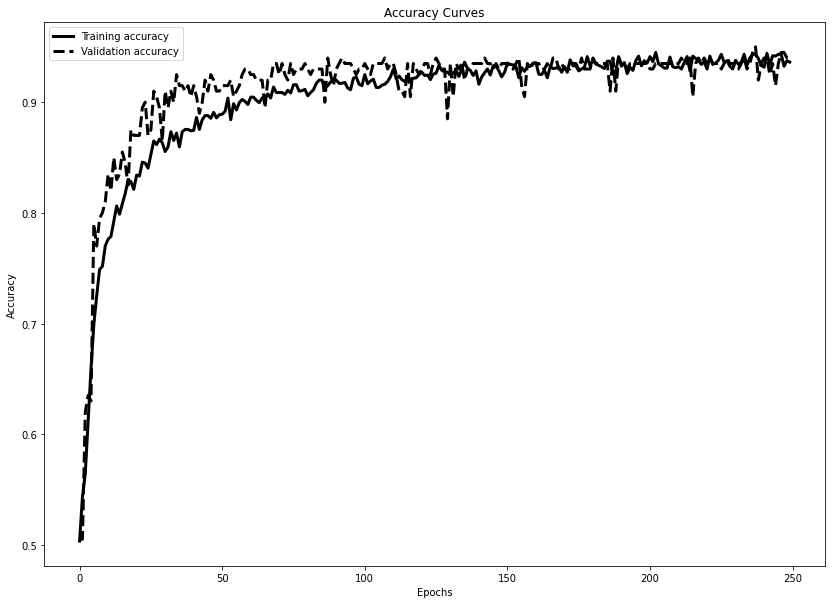

In [10]:
plt.figure(figsize = (14,10))
plt.plot(history.history['accuracy'],'black', linewidth = 3.0,  label = "Training accuracy")
plt.plot(history.history['val_accuracy'],'black', ls = "--",linewidth = 3.0, label = "Validation accuracy")
plt.legend(loc="upper left")
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


model_position.evaluate(test_data_p, test_position)

predictions_position = model_position.predict(test_data_p)
predictions_position = predictions_position.argmax(axis=-1)
print(predictions_position[:10])

test_labels = df.iloc[test_split:, num_col-1:num_col]
test_labels.head(10)


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


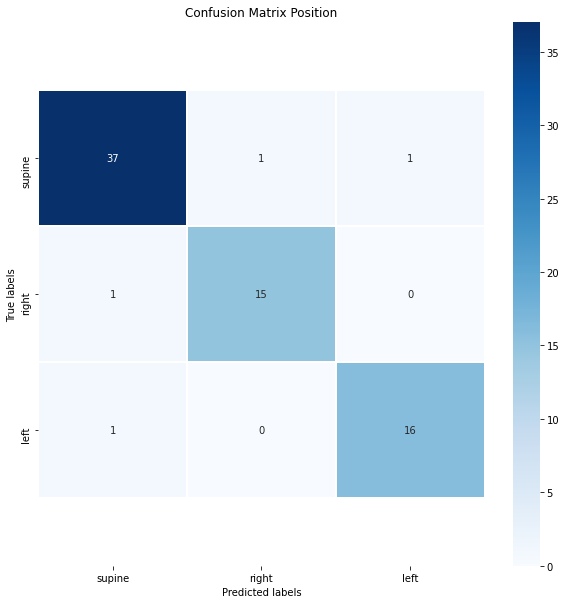

In [11]:
predictions_position = model_position.predict(test_data_p)
predictions_position = predictions_position.argmax(axis=-1)

labels = ['supine', 'right', 'left']
test_labels_p = df.iloc[test_split:, num_col-1:num_col]
cm = confusion_matrix(test_labels_p, predictions_position, [0,1,2])

f,ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax = ax, linewidths=1, fmt = 'd', cmap = "Blues"); #annot=True to annotate cells
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Position'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


In [12]:
# Split dataset in train, val and test
num_col = len(df.columns)
train_split = 2400
test_split = 2600

train_data = df.iloc[0:train_split, [2,5,8]]
val_data = df.iloc[train_split:test_split, [2,5,8]]

train_subject = df.iloc[0:train_split, num_col-2:num_col-1]
train_position = df.iloc[0:train_split, num_col-1:num_col]
val_subject = df.iloc[train_split:test_split, num_col-2:num_col-1]
val_position = df.iloc[train_split:test_split, num_col-1:num_col]

test_data_s = df.iloc[test_split:,[2,5,8]]
test_subject = df.iloc[test_split:, num_col-2:num_col-1]
test_position = df.iloc[test_split:, num_col-1:num_col]

test_data_s = np.array(test_data_s)
test_subject = np.array(test_subject)
test_position = np.array(test_position)
test_subject = to_categorical(test_subject)
test_position = to_categorical(test_position)

while test_subject.shape[1] != 13:
    df = df.sample(frac=1).reset_index(drop=True)
    train_data = df.iloc[0:train_split, [2,5,8]]
    val_data = df.iloc[train_split:test_split, [2,5,8]]

    train_subject = df.iloc[0:train_split, num_col-2:num_col-1]
    train_position = df.iloc[0:train_split, num_col-1:num_col]
    val_subject = df.iloc[train_split:test_split, num_col-2:num_col-1]
    val_position = df.iloc[train_split:test_split, num_col-1:num_col]

    test_data_s = df.iloc[test_split:,[2,5,8]]
    test_subject = df.iloc[test_split:, num_col-2:num_col-1]
    test_position = df.iloc[test_split:, num_col-1:num_col]

    test_data_s = np.array(test_data_s)
    test_subject = np.array(test_subject)
    test_position = np.array(test_position)
    test_subject = to_categorical(test_subject)
    test_position = to_categorical(test_position)
    

In [13]:
# convert to numpy array
train_data = np.array(train_data)
val_data = np.array(val_data)

train_subject = np.array(train_subject)
train_position = np.array(train_position)
val_subject = np.array(val_subject)
val_position = np.array(val_position)

print(train_subject.shape)
print(train_position.shape)
print(val_data.shape)
print(val_subject.shape)
print(val_position.shape)


(2400, 1)
(2400, 1)
(200, 3)
(200, 1)
(200, 1)


In [14]:
# normalize data and build categorical labels
train_subject = to_categorical(train_subject, 13)
train_position = to_categorical(train_position, 3)
val_subject = to_categorical(val_subject, 13)
val_position = to_categorical(val_position, 3)


In [15]:
# model subject
model_subject = Sequential()
model_subject.add(Dense(128, input_dim= 3, activation='relu'))
model_subject.add(Flatten())
model_subject.add(Dropout(0.4))
model_subject.add(Dense(64, activation='relu'))
model_subject.add(Dense(32, activation='relu'))
model_subject.add(Dense(32, activation='relu'))
model_subject.add(Dense(16, activation='relu'))
model_subject.add(Dense(9, activation='relu'))

model_subject.add(Dense(13, activation='softmax'))


In [16]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

model_subject.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])

model_subject.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 16)               

In [17]:
#train position model
history = History()

train_subject = model_subject.fit(train_data, train_subject, validation_data = (val_data, val_subject), epochs=1000, batch_size = 8, callbacks = [history])


Epoch 1/1000
300/300 [==============================] - 1s 4ms/step - loss: 2.5642 - accuracy: 0.0838 - val_loss: 2.5585 - val_accuracy: 0.1450
Epoch 2/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.5526 - accuracy: 0.0917 - val_loss: 2.5266 - val_accuracy: 0.1350
Epoch 3/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.5187 - accuracy: 0.1033 - val_loss: 2.4998 - val_accuracy: 0.1350
Epoch 4/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.4943 - accuracy: 0.1100 - val_loss: 2.4841 - val_accuracy: 0.1200
Epoch 5/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.4802 - accuracy: 0.1254 - val_loss: 2.4748 - val_accuracy: 0.1400
Epoch 6/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.4646 - accuracy: 0.1292 - val_loss: 2.4768 - val_accuracy: 0.1150
Epoch 7/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.4587 - accuracy: 0.1354 - val_loss: 2.4546 - val_accuracy:

300/300 [==============================] - 1s 3ms/step - loss: 2.0627 - accuracy: 0.2871 - val_loss: 2.0300 - val_accuracy: 0.2850
Epoch 58/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.0636 - accuracy: 0.2717 - val_loss: 2.0672 - val_accuracy: 0.2550
Epoch 59/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.0351 - accuracy: 0.2829 - val_loss: 2.0558 - val_accuracy: 0.2800
Epoch 60/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.0275 - accuracy: 0.2962 - val_loss: 2.0138 - val_accuracy: 0.3050
Epoch 61/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.0300 - accuracy: 0.2829 - val_loss: 2.0409 - val_accuracy: 0.2800
Epoch 62/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.0322 - accuracy: 0.2871 - val_loss: 2.0565 - val_accuracy: 0.2900
Epoch 63/1000
300/300 [==============================] - 1s 3ms/step - loss: 2.0188 - accuracy: 0.3088 - val_loss: 1.9981 - val_accuracy: 0.3750

300/300 [==============================] - 1s 3ms/step - loss: 1.7836 - accuracy: 0.3663 - val_loss: 1.8180 - val_accuracy: 0.4150
Epoch 114/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.7764 - accuracy: 0.3754 - val_loss: 1.7852 - val_accuracy: 0.4150
Epoch 115/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.7795 - accuracy: 0.3746 - val_loss: 1.7847 - val_accuracy: 0.4150
Epoch 116/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.7891 - accuracy: 0.3617 - val_loss: 1.7950 - val_accuracy: 0.4050
Epoch 117/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.7891 - accuracy: 0.3738 - val_loss: 1.8558 - val_accuracy: 0.3500
Epoch 118/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.7776 - accuracy: 0.3812 - val_loss: 1.8421 - val_accuracy: 0.3750
Epoch 119/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.7738 - accuracy: 0.3738 - val_loss: 1.8369 - val_accuracy: 

300/300 [==============================] - 1s 3ms/step - loss: 1.6526 - accuracy: 0.4258 - val_loss: 1.7061 - val_accuracy: 0.4650
Epoch 170/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.6321 - accuracy: 0.4271 - val_loss: 1.6373 - val_accuracy: 0.4500
Epoch 171/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.6460 - accuracy: 0.4342 - val_loss: 1.7230 - val_accuracy: 0.4050
Epoch 172/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.6424 - accuracy: 0.4333 - val_loss: 1.7120 - val_accuracy: 0.4250
Epoch 173/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.6451 - accuracy: 0.4250 - val_loss: 1.6876 - val_accuracy: 0.4600
Epoch 174/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.6087 - accuracy: 0.4325 - val_loss: 1.6333 - val_accuracy: 0.4700
Epoch 175/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.6309 - accuracy: 0.4383 - val_loss: 1.6454 - val_accuracy: 

300/300 [==============================] - 1s 3ms/step - loss: 1.5346 - accuracy: 0.4771 - val_loss: 1.5082 - val_accuracy: 0.5050
Epoch 226/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.5390 - accuracy: 0.4663 - val_loss: 1.4920 - val_accuracy: 0.5000
Epoch 227/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.5348 - accuracy: 0.4663 - val_loss: 1.5710 - val_accuracy: 0.4450
Epoch 228/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.4990 - accuracy: 0.4762 - val_loss: 1.4834 - val_accuracy: 0.5100
Epoch 229/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.5642 - accuracy: 0.4608 - val_loss: 1.4973 - val_accuracy: 0.5000
Epoch 230/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.5243 - accuracy: 0.4683 - val_loss: 1.5933 - val_accuracy: 0.4800
Epoch 231/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.5138 - accuracy: 0.4737 - val_loss: 1.4965 - val_accuracy: 

300/300 [==============================] - 1s 3ms/step - loss: 1.4229 - accuracy: 0.4983 - val_loss: 1.4460 - val_accuracy: 0.5050
Epoch 282/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.4376 - accuracy: 0.4892 - val_loss: 1.4774 - val_accuracy: 0.5100
Epoch 283/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.4200 - accuracy: 0.4921 - val_loss: 1.4630 - val_accuracy: 0.5150
Epoch 284/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.4253 - accuracy: 0.5067 - val_loss: 1.4038 - val_accuracy: 0.5100
Epoch 285/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.4474 - accuracy: 0.4921 - val_loss: 1.4680 - val_accuracy: 0.5350
Epoch 286/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.4002 - accuracy: 0.5079 - val_loss: 1.4130 - val_accuracy: 0.5150
Epoch 287/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.4153 - accuracy: 0.5058 - val_loss: 1.4592 - val_accuracy: 

Epoch 337/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.3654 - accuracy: 0.5304 - val_loss: 1.3917 - val_accuracy: 0.5850
Epoch 338/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.3497 - accuracy: 0.5321 - val_loss: 1.3374 - val_accuracy: 0.5600
Epoch 339/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.3577 - accuracy: 0.5354 - val_loss: 1.3016 - val_accuracy: 0.5950
Epoch 340/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.3660 - accuracy: 0.5221 - val_loss: 1.3631 - val_accuracy: 0.5500
Epoch 341/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.3404 - accuracy: 0.5425 - val_loss: 1.3159 - val_accuracy: 0.5550
Epoch 342/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.3690 - accuracy: 0.5308 - val_loss: 1.3847 - val_accuracy: 0.5300
Epoch 343/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.3383 - accuracy: 0.5421 - val_loss: 1.3751 -

300/300 [==============================] - 1s 3ms/step - loss: 1.3224 - accuracy: 0.5529 - val_loss: 1.2743 - val_accuracy: 0.5800
Epoch 394/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2966 - accuracy: 0.5733 - val_loss: 1.2758 - val_accuracy: 0.5900
Epoch 395/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2852 - accuracy: 0.5638 - val_loss: 1.2786 - val_accuracy: 0.5950
Epoch 396/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2580 - accuracy: 0.5692 - val_loss: 1.2413 - val_accuracy: 0.6150
Epoch 397/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.3006 - accuracy: 0.5700 - val_loss: 1.2772 - val_accuracy: 0.6050
Epoch 398/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2826 - accuracy: 0.5558 - val_loss: 1.2957 - val_accuracy: 0.6000
Epoch 399/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2712 - accuracy: 0.5792 - val_loss: 1.2928 - val_accuracy: 

300/300 [==============================] - 1s 3ms/step - loss: 1.2415 - accuracy: 0.5883 - val_loss: 1.2614 - val_accuracy: 0.5950
Epoch 450/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2372 - accuracy: 0.5829 - val_loss: 1.2687 - val_accuracy: 0.6200
Epoch 451/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2071 - accuracy: 0.5850 - val_loss: 1.1757 - val_accuracy: 0.6250
Epoch 452/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2470 - accuracy: 0.5717 - val_loss: 1.2152 - val_accuracy: 0.6250
Epoch 453/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2444 - accuracy: 0.5729 - val_loss: 1.2483 - val_accuracy: 0.6500
Epoch 454/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2479 - accuracy: 0.5804 - val_loss: 1.2969 - val_accuracy: 0.5800
Epoch 455/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2322 - accuracy: 0.5904 - val_loss: 1.2219 - val_accuracy: 

300/300 [==============================] - 1s 3ms/step - loss: 1.2104 - accuracy: 0.6025 - val_loss: 1.2504 - val_accuracy: 0.5900
Epoch 506/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2005 - accuracy: 0.5946 - val_loss: 1.1587 - val_accuracy: 0.6550
Epoch 507/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.1712 - accuracy: 0.6075 - val_loss: 1.1852 - val_accuracy: 0.6400
Epoch 508/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.1909 - accuracy: 0.5913 - val_loss: 1.1537 - val_accuracy: 0.6200
Epoch 509/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.1811 - accuracy: 0.6050 - val_loss: 1.1591 - val_accuracy: 0.6500
Epoch 510/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.2099 - accuracy: 0.5992 - val_loss: 1.2100 - val_accuracy: 0.6050
Epoch 511/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.1760 - accuracy: 0.6008 - val_loss: 1.1858 - val_accuracy: 

300/300 [==============================] - 1s 5ms/step - loss: 1.1472 - accuracy: 0.6150 - val_loss: 1.1371 - val_accuracy: 0.6550
Epoch 562/1000
300/300 [==============================] - 2s 6ms/step - loss: 1.2064 - accuracy: 0.6046 - val_loss: 1.1975 - val_accuracy: 0.6250
Epoch 563/1000
300/300 [==============================] - 2s 6ms/step - loss: 1.1527 - accuracy: 0.6208 - val_loss: 1.1293 - val_accuracy: 0.6450
Epoch 564/1000
300/300 [==============================] - 2s 6ms/step - loss: 1.1627 - accuracy: 0.6083 - val_loss: 1.1332 - val_accuracy: 0.6650
Epoch 565/1000
300/300 [==============================] - 2s 8ms/step - loss: 1.1458 - accuracy: 0.6383 - val_loss: 1.1683 - val_accuracy: 0.6850
Epoch 566/1000
300/300 [==============================] - 2s 7ms/step - loss: 1.1323 - accuracy: 0.6267 - val_loss: 1.1966 - val_accuracy: 0.6600
Epoch 567/1000
300/300 [==============================] - 2s 6ms/step - loss: 1.1603 - accuracy: 0.6167 - val_loss: 1.1268 - val_accuracy: 

300/300 [==============================] - 1s 3ms/step - loss: 1.1102 - accuracy: 0.6296 - val_loss: 1.1541 - val_accuracy: 0.6600
Epoch 617/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.1099 - accuracy: 0.6292 - val_loss: 1.1589 - val_accuracy: 0.6050
Epoch 618/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.1056 - accuracy: 0.6338 - val_loss: 1.1718 - val_accuracy: 0.6150
Epoch 619/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.1334 - accuracy: 0.6254 - val_loss: 1.0856 - val_accuracy: 0.6450
Epoch 620/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.1321 - accuracy: 0.6233 - val_loss: 1.1194 - val_accuracy: 0.6650
Epoch 621/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.0934 - accuracy: 0.6371 - val_loss: 1.1253 - val_accuracy: 0.6550
Epoch 622/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.0928 - accuracy: 0.6488 - val_loss: 1.1231 - val_accuracy: 

Epoch 672/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0894 - accuracy: 0.6454 - val_loss: 1.1068 - val_accuracy: 0.6550
Epoch 673/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0938 - accuracy: 0.6413 - val_loss: 1.0581 - val_accuracy: 0.6800
Epoch 674/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.0896 - accuracy: 0.6550 - val_loss: 1.0581 - val_accuracy: 0.6800
Epoch 675/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.1090 - accuracy: 0.6496 - val_loss: 1.1350 - val_accuracy: 0.6550
Epoch 676/1000
300/300 [==============================] - 2s 5ms/step - loss: 1.0791 - accuracy: 0.6475 - val_loss: 1.1440 - val_accuracy: 0.6400
Epoch 677/1000
300/300 [==============================] - 2s 5ms/step - loss: 1.0952 - accuracy: 0.6392 - val_loss: 1.1797 - val_accuracy: 0.6250
Epoch 678/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.1343 - accuracy: 0.6167 - val_loss: 1.1390 -

300/300 [==============================] - 2s 5ms/step - loss: 1.0464 - accuracy: 0.6554 - val_loss: 1.2328 - val_accuracy: 0.6650
Epoch 729/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0706 - accuracy: 0.6521 - val_loss: 1.0903 - val_accuracy: 0.6800
Epoch 730/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0295 - accuracy: 0.6579 - val_loss: 1.0651 - val_accuracy: 0.6850
Epoch 731/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.0624 - accuracy: 0.6463 - val_loss: 1.0448 - val_accuracy: 0.6600
Epoch 732/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.0535 - accuracy: 0.6558 - val_loss: 1.0756 - val_accuracy: 0.6750
Epoch 733/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0897 - accuracy: 0.6546 - val_loss: 1.0738 - val_accuracy: 0.6550
Epoch 734/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0435 - accuracy: 0.6575 - val_loss: 1.1014 - val_accuracy: 

Epoch 784/1000
300/300 [==============================] - 2s 5ms/step - loss: 1.0399 - accuracy: 0.6596 - val_loss: 1.1175 - val_accuracy: 0.6800
Epoch 785/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0512 - accuracy: 0.6600 - val_loss: 1.0928 - val_accuracy: 0.6800
Epoch 786/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0485 - accuracy: 0.6508 - val_loss: 1.0184 - val_accuracy: 0.6750
Epoch 787/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0094 - accuracy: 0.6717 - val_loss: 1.0176 - val_accuracy: 0.6950
Epoch 788/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0686 - accuracy: 0.6608 - val_loss: 0.9938 - val_accuracy: 0.6900
Epoch 789/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0194 - accuracy: 0.6742 - val_loss: 1.0476 - val_accuracy: 0.6550
Epoch 790/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0264 - accuracy: 0.6654 - val_loss: 1.0861 -

300/300 [==============================] - 1s 3ms/step - loss: 1.0132 - accuracy: 0.6712 - val_loss: 1.1499 - val_accuracy: 0.6850
Epoch 841/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.0162 - accuracy: 0.6746 - val_loss: 1.1109 - val_accuracy: 0.6900
Epoch 842/1000
300/300 [==============================] - 1s 4ms/step - loss: 0.9880 - accuracy: 0.6771 - val_loss: 1.1362 - val_accuracy: 0.6800
Epoch 843/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0523 - accuracy: 0.6571 - val_loss: 1.1599 - val_accuracy: 0.6850
Epoch 844/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0100 - accuracy: 0.6679 - val_loss: 1.2306 - val_accuracy: 0.6200
Epoch 845/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0435 - accuracy: 0.6667 - val_loss: 1.0325 - val_accuracy: 0.7000
Epoch 846/1000
300/300 [==============================] - 1s 4ms/step - loss: 1.0293 - accuracy: 0.6662 - val_loss: 1.0679 - val_accuracy: 

300/300 [==============================] - 1s 3ms/step - loss: 0.9948 - accuracy: 0.6733 - val_loss: 1.0947 - val_accuracy: 0.6950
Epoch 897/1000
300/300 [==============================] - 1s 4ms/step - loss: 0.9669 - accuracy: 0.6812 - val_loss: 1.0064 - val_accuracy: 0.7200
Epoch 898/1000
300/300 [==============================] - 1s 3ms/step - loss: 0.9997 - accuracy: 0.6796 - val_loss: 1.0140 - val_accuracy: 0.7350
Epoch 899/1000
300/300 [==============================] - 1s 4ms/step - loss: 0.9892 - accuracy: 0.6779 - val_loss: 1.1227 - val_accuracy: 0.6550
Epoch 900/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.0601 - accuracy: 0.6488 - val_loss: 1.1034 - val_accuracy: 0.7050
Epoch 901/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.0355 - accuracy: 0.6629 - val_loss: 1.0835 - val_accuracy: 0.6850
Epoch 902/1000
300/300 [==============================] - 1s 3ms/step - loss: 1.0239 - accuracy: 0.6725 - val_loss: 1.0999 - val_accuracy: 

300/300 [==============================] - 1s 3ms/step - loss: 0.9714 - accuracy: 0.6829 - val_loss: 1.0403 - val_accuracy: 0.7000
Epoch 953/1000
300/300 [==============================] - 1s 5ms/step - loss: 0.9615 - accuracy: 0.6871 - val_loss: 1.0825 - val_accuracy: 0.6850
Epoch 954/1000
300/300 [==============================] - 1s 5ms/step - loss: 1.0186 - accuracy: 0.6767 - val_loss: 1.0636 - val_accuracy: 0.7000
Epoch 955/1000
300/300 [==============================] - 1s 4ms/step - loss: 0.9638 - accuracy: 0.6862 - val_loss: 1.0417 - val_accuracy: 0.6950
Epoch 956/1000
300/300 [==============================] - 2s 6ms/step - loss: 0.9631 - accuracy: 0.6875 - val_loss: 1.0881 - val_accuracy: 0.6800
Epoch 957/1000
300/300 [==============================] - 1s 5ms/step - loss: 0.9498 - accuracy: 0.6938 - val_loss: 1.1201 - val_accuracy: 0.6900
Epoch 958/1000
300/300 [==============================] - 1s 4ms/step - loss: 0.9677 - accuracy: 0.6967 - val_loss: 1.0703 - val_accuracy: 

3/3 [==============================] - 0s 5ms/step - loss: 1.4715 - accuracy: 0.7222
[ 7 12  8 11  9  5 12  0  9  5]


,Subject
2600,7
2601,12
2602,8
2603,6
2604,9
2605,5
2606,12
2607,0
2608,8
2609,5


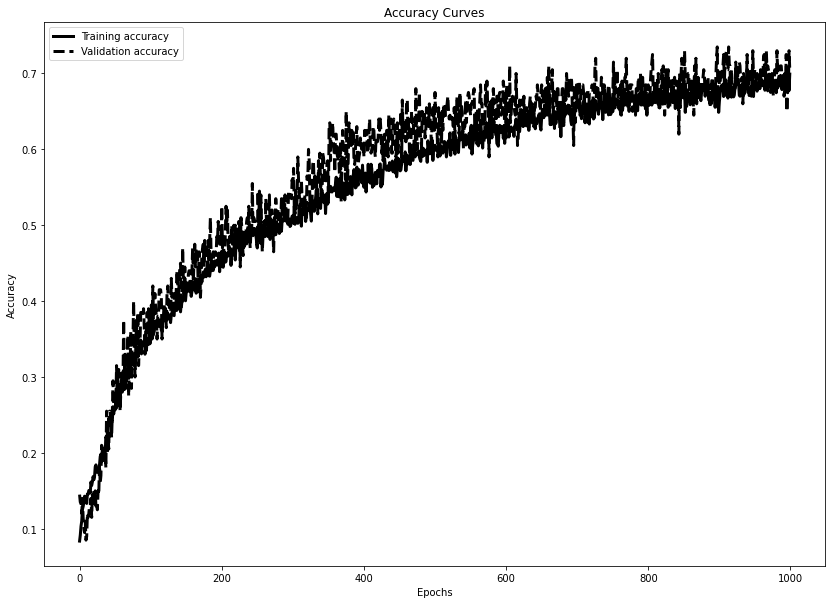

In [18]:
plt.figure(figsize = (14,10))
plt.plot(history.history['accuracy'],'black', linewidth = 3.0,  label = "Training accuracy")
plt.plot(history.history['val_accuracy'],'black', ls = "--",linewidth = 3.0, label = "Validation accuracy")
plt.legend(loc="upper left")
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

model_subject.evaluate(test_data_s, test_subject)

predictions_subject = model_subject.predict(test_data_s)
predictions_subject = predictions_subject.argmax(axis=-1)
print(predictions_subject[:10])

test_labels = df.iloc[test_split:, num_col-2:num_col-1]
test_labels.head(10)


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


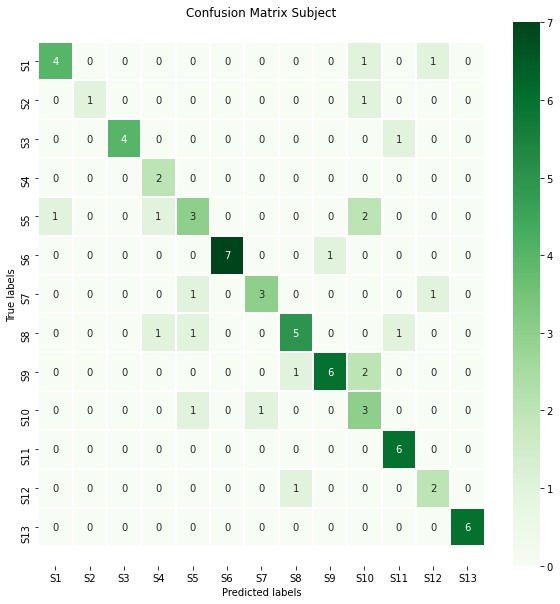

In [19]:
predictions_subject = model_subject.predict(test_data_s)
predictions_subject = predictions_subject.argmax(axis=-1)

labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6','S7', 'S8', 'S9','S10', 'S11', 'S12','S13']
test_labels_s = df.iloc[test_split:, num_col-2:num_col-1]
cm = confusion_matrix(test_labels_s, predictions_subject, [0,1,2,3,4,5,6,7,8,9,10,11,12])

f,ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax = ax, linewidths=1, fmt = 'd', cmap="Greens"); #annot=True to annotate cells
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Subject'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [20]:
#save model and architecture to single file
model_subject.save("Model/model_subject_2.h5")
model_position.save("Model/model_position_2.h5")

with open('Model/test_2.pkl', 'wb') as f: 
    pickle.dump([test_data_s, test_data_p, test_subject, test_position, test_labels_s, test_labels_p], f)
    